In [14]:
import os.path

import pandas as pd
from flib import Db
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
ch = Db("formats")
pg = Db('db_postgresql_spb')

STOCK_DEFAULT_MIN = 2

In [16]:
def prepare_rrc_full_stock(rrc_stock: pd.DataFrame, rrc_fix: pd.DataFrame) -> pd.DataFrame:
    """
    Объеденить данные остатков и потребностей, посчитать доступность, отметить топовые категории.
    """
    merged = rrc_stock.merge(rrc_fix, on=['rrc_id', 'product'], how='left')
    merged['fix'] = merged['fix'].fillna(0)
    merged['max'] = merged['fix'].apply(lambda x: max(x, STOCK_DEFAULT_MIN))
    merged['access'] = merged['stock'] > merged['max']

    return merged

def get_rrc_stock(db: Db, sql) -> pd.DataFrame:
    df = db.read_sql(sql)
    # Приведение типов по аналогии
    df['stock'] = pd.to_numeric(df['stock'])
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['rrc_id'] = df['rrc_id'].astype(str)
    df['product'] = df['product'].astype(str)
    df['category_4_id'] = df['category_4_id'].astype(str)
    return df

def get_rrc_fix(db: Db, sql) -> pd.DataFrame:
    df = db.read_sql(sql)
    df['rrc_id'] = df['rrc_id'].astype(str)
    df['product'] = df['product'].astype(str)
    return df

def get_tp_stock(db: Db, sql) -> pd.DataFrame:
    df = db.read_sql(sql)
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['rrc_id'] = df['rrc_id'].astype(str)
    df['branch_id'] = df['branch_id'].astype(str)
    df['category_4_id'] = df['category_4_id'].astype(str)
    df['product'] = df['product'].astype(str)
    return df

def aggregate_rrc_table(rrc_full_stock: pd.DataFrame) -> pd.DataFrame:
    """
    Группировка статистики по РРЦ и категориям.
    """
    agg_columns = [
        'date', 'div', 'rrc_name', 'rrc_id',
        'category_1_name', 'category_4_name', 'category_4_id', 'access'
    ]
    rrc_table = rrc_full_stock.groupby(agg_columns, as_index=False).agg(
        product_count=('product', 'nunique')
    )
    return rrc_table

def compute_tp_stock_group(tp_stock: pd.DataFrame) -> pd.DataFrame:
    """
    Подсчитать количество продуктов на ТП на уровне категорий.
    """
    grouped = tp_stock.groupby([
        'date', 'rrc_id', 'branch', 'branch_id', 'category_1_name', 'category_4_name', 'category_4_id'
    ], as_index=False)['product'].count().rename(columns={'product': 'product_count_tp'})
    return grouped

def compute_available_tp_stock(rrc_full_stock: pd.DataFrame, tp_stock: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитать доступные для наполнения товары для ТП (отсутствующие на филиале).
    """
    tp = tp_stock.copy()
    rrc = rrc_full_stock.query('access == True')[
        ['date', 'div', 'rrc_name', 'rrc_id', 'category_1_name', 'category_4_name', 'category_4_id', 'product']
    ]

    branches = tp[['rrc_id', 'branch', 'branch_id']].drop_duplicates()
    rrc_branches = pd.merge(rrc, branches, on='rrc_id', how='left')

    compare = pd.merge(
        rrc_branches,
        tp,
        how='left',
        on=['rrc_id', 'branch_id', 'category_4_id', 'product', 'date'],
        indicator=True,
        suffixes=('', '_tp')
    )

    missing_products = compare[compare['_merge'] == 'left_only']

    agg_columns = [
        'date', 'div', 'rrc_name', 'rrc_id', 'branch', 'branch_id',
        'category_1_name', 'category_4_name', 'category_4_id',
    ]
    available_tp_stock = missing_products.groupby(agg_columns, as_index=False).agg(
        product_count=('product', 'nunique')
    )
    return available_tp_stock

In [17]:
rrc_stock_query = '''
SELECT DISTINCT
	(sid.`Период`) date ,
    b.territory_4_name AS div,
    b.name AS rrc_name,
    b.id AS rrc_id,
    p.category_1_name AS category_1_name,
    p.category_4_name AS category_4_name,
    p.category_4_id AS category_4_id,
    sid.`Номенклатура` AS product,
    sid.`Количество` AS stock
FROM RN.Schet_41_Itogi_day sid
JOIN dict.branch b ON sid.`Филиал` = b.id
JOIN dict.product p ON sid.`Номенклатура` = p.id
WHERE
    sid.`Период` >= '2025-05-10'
    AND sid.`Количество` > 0
    AND b.is_deleted = 0
    AND b.type_name = 'РРЦ'
    AND p.category_1_code IN ('AM18266', 'ID43922', 'AM24114', 'ID43921', 'EY74273', 'IW79893', 'IW79895', 'GH19556')
    AND lowerUTF8(b.name) NOT ILIKE '%сдх%'
    AND b.id = '60598168-7e8c-400d-95ab-a80b9f7f7c98'
    AND p.federal_status_id IN ('47c9ca4e-48c1-4485-9548-ded3d257dfd7', '52c63b28-caa7-4cc5-a824-0d91ecad1ad7', '0c73a815-ea99-4a82-b467-bdf07eee14b5', '94e66092-7dc5-4147-a442-2b66f23d5557')
'''

rrc_fix_query = '''
SELECT
    fix."Филиал" AS rrc_id,
    fix."Товар" AS product,
    MAX(fix."Количество") AS fix
FROM reg.total_product_fixes_by_stage fix
JOIN dim.dim_branches db ON fix."Филиал" = db."Ссылка" AND db."ВидФилиала" = 'РРЦ'
WHERE fix."Количество" > 0 
	AND fix."Филиал" = '60598168-7e8c-400d-95ab-a80b9f7f7c98'
GROUP BY rrc_id, product
'''

tp_stock_query = '''
SELECT DISTINCT
    sid.`Период` as date,
    b.rrc_id AS rrc_id,
    b.name AS branch,
    b.id AS branch_id,
    p.category_1_name as category_1_name,
    p.category_4_name as category_4_name,
    p.category_4_id as category_4_id,
    sid.`Номенклатура` AS product
FROM RN.Schet_41_Itogi_day sid
JOIN dict.branch b ON sid.`Филиал` = b.id
JOIN dict.product p ON sid.`Номенклатура` = p.id
JOIN (
    SELECT BranchId, BranchConfModel
    FROM formats_bi.GroupOfMeasuresOnBranchStats
    ORDER BY Period DESC
    LIMIT 1 BY BranchId, BranchConfModel
) mkf ON b.id = mkf.BranchId
WHERE
    sid.`Период` >= '2025-05-10'
    AND sid.`Количество` > 0
    AND b.is_deleted = 0
    AND b.type_name = 'Дисконт центр'
    AND p.category_1_code IN ('AM18266', 'ID43922', 'AM24114', 'ID43921', 'EY74273', 'IW79893', 'IW79895', 'GH19556')
    AND mkf.BranchConfModel NOT IN ('Не задана', 'ПВЗ')
    AND lowerUTF8(b.name) NOT ILIKE '%достав%'
    AND lowerUTF8(b.name) NOT ILIKE '%точк%'
    AND b.id = '293eaa42-e8b1-11ed-b71a-00155dce5800'
    AND b.name NOT IN ('Рыбинск ТП', 'Бийск Технопоинт на Советской', 'СПб Склад в Горелово ТП',
                        'Иркутск Торг.Склад Мельниковский', 'Калининград Орудийная ТП', 'Барнаул Технопоинт СК',
                        'Южно-Сахалинск Склад ТП', 'Волгоград Торг. Склад', 'Воронеж Торг. Склад',
                        'Киров ТП на Щорса', 'Чита Торг. Склад ТП', 'Владивосток Днепровская ТП ',
                        'Краснодар Магазин-склад ДНС', 'Тула Торг. Склад', 'Кра Торг. Склад ТП',
                        'Владимир Технопоинт', 'Новосиб Технопоинт СК Сибирский', 'Ростов Магазин-склад Технопоинт new', 'Рыбинск ТП'
                        )
'''

In [18]:
rrc_stock = get_rrc_stock(ch, rrc_stock_query)
rrc_fix = get_rrc_fix(pg, rrc_fix_query)

rrc_full_stock = prepare_rrc_full_stock(rrc_stock, rrc_fix)
rrc_table = aggregate_rrc_table(rrc_full_stock)

tp_stock = get_tp_stock(ch, tp_stock_query)
tp_stock_group = compute_tp_stock_group(tp_stock)
available_tp_stock = compute_available_tp_stock(rrc_full_stock, tp_stock)



In [19]:
tp_stock.head()

,date,rrc_id,branch,branch_id,category_1_name,category_4_name,category_4_id,product
0,2025-06-01,60598168-7e8c-400d-95ab-a80b9f7f7c98,Кра ТЦ Красноярье ТП,293eaa42-e8b1-11ed-b71a-00155dce5800,05. ТВ и Аудио,Колонки портативные,0882e52a-796e-11e2-b7ec-00155d030b1f,045b23cb-c80d-498d-8002-e1d8ffd2d02c
1,2025-06-01,60598168-7e8c-400d-95ab-a80b9f7f7c98,Кра ТЦ Красноярье ТП,293eaa42-e8b1-11ed-b71a-00155dce5800,06. Офисная техника,Мышь офисная,05583016-70e7-11e2-b24e-00155d030b1f,7a6e7459-617f-11e5-8003-00155d03361b
2,2025-06-01,60598168-7e8c-400d-95ab-a80b9f7f7c98,Кра ТЦ Красноярье ТП,293eaa42-e8b1-11ed-b71a-00155dce5800,01. Мобильные устройства,Сотовый телефон,fd72100f-70e6-11e2-b24e-00155d030b1f,e163e895-8b5c-4fc4-8006-8739a6d54995
3,2025-06-01,60598168-7e8c-400d-95ab-a80b9f7f7c98,Кра ТЦ Красноярье ТП,293eaa42-e8b1-11ed-b71a-00155dce5800,08. Аксессуары,Кабель для мобильных устройств,539a1afb-61c6-11e5-8003-00155d03361b,ec2cd41a-774d-4160-8007-16571c119831
4,2025-06-01,60598168-7e8c-400d-95ab-a80b9f7f7c98,Кра ТЦ Красноярье ТП,293eaa42-e8b1-11ed-b71a-00155dce5800,07. DIY и Household,АКБ и ЗУ для электроинструмента,d3fd710e-8eee-11e4-88cf-00155d03361b,9bb0b980-ba30-4e72-8007-7bdffd1cec13


In [20]:
t_a = available_tp_stock.groupby(['date', 'branch'], as_index=False)['product_count'].sum()
t_s = tp_stock_group.groupby(['date', 'branch'], as_index=False)['product_count_tp'].sum()
t = pd.merge(t_a, t_s, how='inner', on=['date', 'branch'])
t = t.rename(columns={'product_count': 'stock_potential', 'product_count_tp': 'stock_current'})
t['diff'] = t['stock_current'] / (t['stock_current'] + t['stock_potential']) * 100
t['date'] = pd.to_datetime(t.date)
t = t.sort_values('date')

In [40]:
t['stock_current']

0     18724
1     18719
2     18723
3     18697
4     18673
5     18762
6     18596
7     18874
8     18933
9     19033
10    18980
11    18940
12    18912
13    18804
14    18724
15    18652
16    18594
17    18552
18    18475
19    18432
20    18358
21    18647
22    19203
23    20191
24    20169
25    20118
26    20108
27    20045
28    20170
29    20179
30    20222
31    20229
32    20204
33    20150
34    20213
35    20342
36    20389
37    20449
38    20498
39    20542
40    20540
41    20556
42    20570
43    20675
44    20883
45    20869
46    20925
47    20889
48    20863
49    20822
50    20787
51    20804
Name: stock_current, dtype: int64

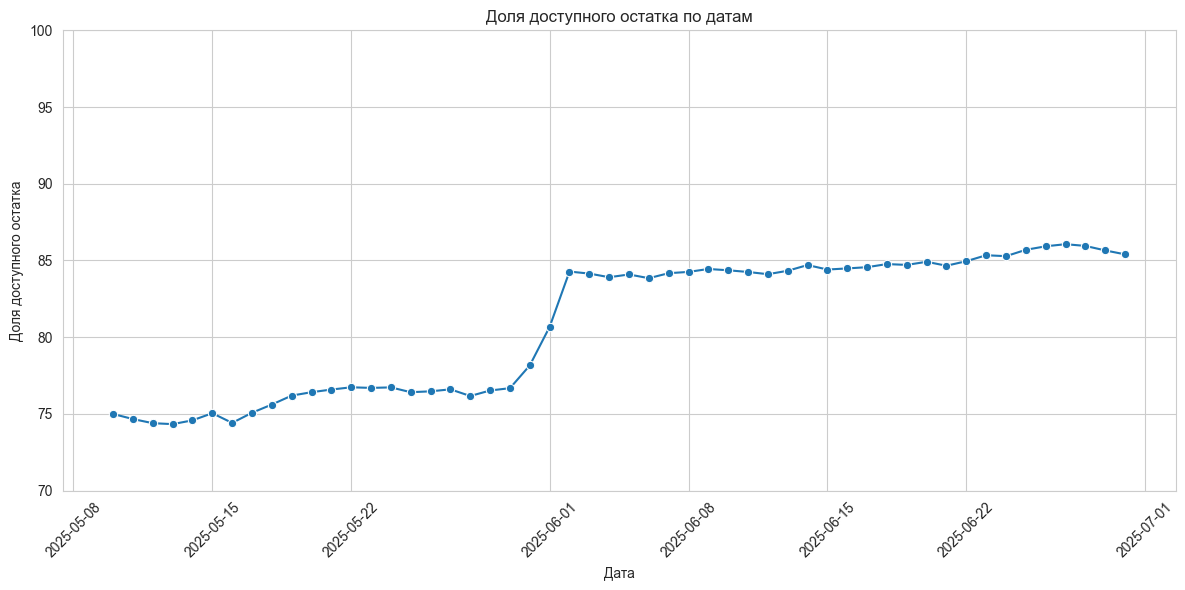

In [21]:
plt.figure(figsize=(12,6))
sns.lineplot(data=t, x='date', y='diff', marker='o')
plt.title('Доля доступного остатка по датам')
plt.xlabel('Дата')
plt.ylabel('Доля доступного остатка')
plt.ylim(70, 100)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

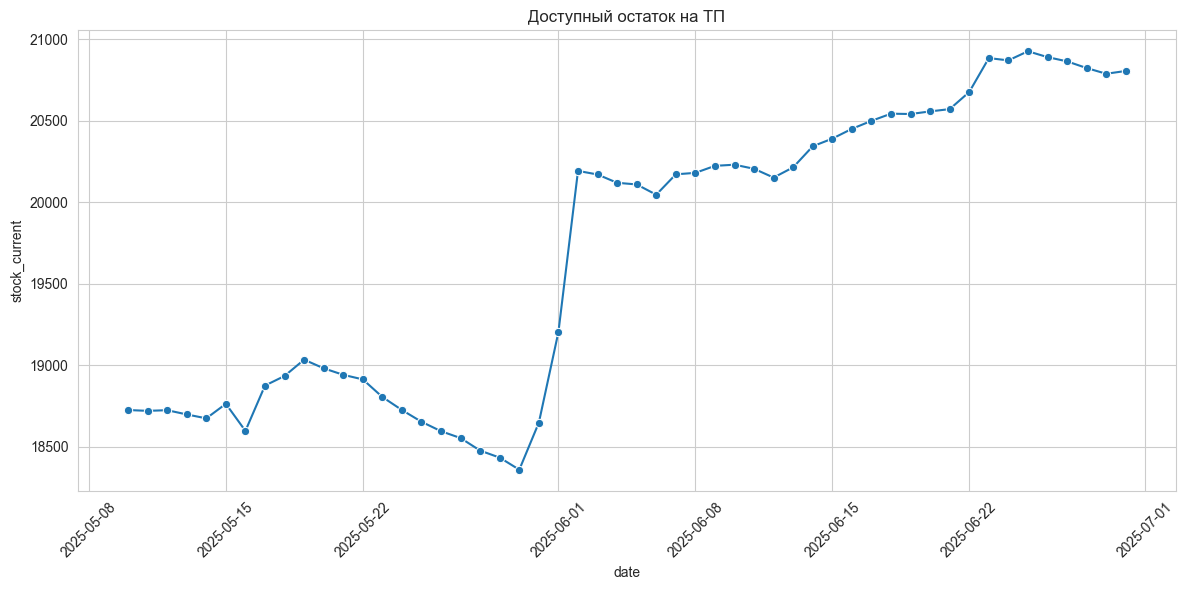

In [42]:
plt.figure(figsize=(12,6))
sns.lineplot(data=t, x='date', y='stock_current', marker='o')
plt.title('Доступный остаток на ТП')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

In [27]:
movements = ch.read_sql('''
SELECT 
	date_day,
	branch_name, 
	uniqExact(product_code) sku
FROM formats.mart_product_movements_by_type mpmbt
WHERE 
	branch_guid = '293eaa42-e8b1-11ed-b71a-00155dce5800'
	AND date_day >= '2025-04-01'
	AND mpmbt.general> 0 
GROUP BY 
	date_day, branch_name
''')

In [28]:
movements['rolling_sku'] = movements['sku'].rolling(7).mean()

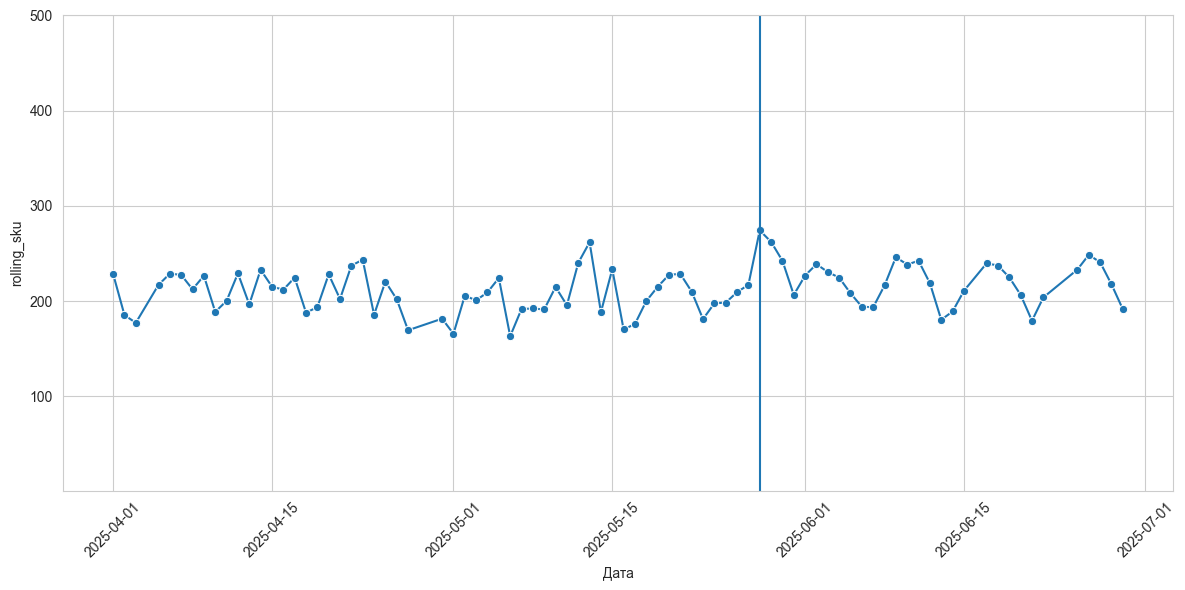

In [34]:
import datetime as dt

plt.figure(figsize=(12,6))
sns.lineplot(data=movements, x='date_day', y='rolling_sku', marker='o')
plt.xlabel('Дата')
plt.ylim(1, 500)
plt.xticks(rotation=45)
plt.axvline(dt.datetime(2025, 5, 28))
plt.grid(True)
plt.tight_layout()

- Основная таблица. 

Дата - Дивизион - РРЦ - ТП - Департамент - Категория - Остаток ТП - Потенциальный Остаток ТП - Доступный остаток РРЦ - Не доступный остаток РРЦ - Остаток РРЦ - Доля Доступного Асс ТП.  


In [51]:
# available_tp_stock - доступный ассортимент для наполнения ТП
# tp_stock_group - остаток тп
# rrc_table - остаток РРЦ. 

In [79]:
final_stock_tp = tp_stock_group[['date', 'rrc_id', 'branch', 'branch_id',  'category_4_id', 'product_count_tp']]\
                    .merge(
                        available_tp_stock[['date', 'rrc_id', 'branch', 'branch_id',  'category_4_id', 'product_count']], 
                        on=['date', 'rrc_id', 'branch', 'branch_id',  'category_4_id'],
                        how='left'
                        )\
                    .fillna(0)
final_stock_tp = final_stock_tp.rename(columns={'product_count': 'potential_stock_tp', 'product_count_tp': 'stock_tp'})


In [80]:
final_stock_rrc = rrc_table.pivot_table(
                                index=['date', 'div', 'rrc_name', 'rrc_id', 'category_1_name', 'category_4_name', 'category_4_id'],
                                columns='access',
                                values='product_count',
                                aggfunc='sum',
                                fill_value=0)\
                                .reset_index()\
                                .rename(columns={True: 'available_stock_rrc', False: 'not_available_stock_rrc'}
                                )
final_stock_rrc['full_stock_rrc'] = final_stock_rrc['available_stock_rrc'] + final_stock_rrc['not_available_stock_rrc']

In [92]:
df_c_p_stock = final_stock_rrc.merge(final_stock_tp, on=['date', 'rrc_id', 'category_4_id'], how='left')
df_c_p_stock['branch'] = df_c_p_stock.branch.fillna(method='bfill')
df_c_p_stock['branch_id'] = df_c_p_stock.branch_id.fillna(method='bfill')
df_c_p_stock['stock_tp'] = df_c_p_stock.stock_tp.fillna(0)
df_c_p_stock['potential_stock_tp'] = df_c_p_stock.potential_stock_tp.fillna(0)
df_c_p_stock['diff'] = (df_c_p_stock['stock_tp'] / (df_c_p_stock['stock_tp'] + df_c_p_stock['potential_stock_tp']) * 100).fillna(0)

- Таблица целевых движений 

Дата - Дивизион - РРЦ - ТП - МКФ - Департамент - Категория - Вид движения - Онлайн|Офлайн - СКУ - ШТ - Себестоимость.  

In [ ]:
query_sales = '''

'''